In [ ]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medical-abstaract-dataset/medical_tc_test.csv
/kaggle/input/medical-abstaract-dataset/medical_tc_labels.csv
/kaggle/input/medical-abstaract-dataset/medical_tc_train.csv


In [2]:
!pip install transformers datasets scikit-learn matplotlib seaborn pandas

In [3]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

2025-04-25 09:40:25.464018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745574025.489354     293 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745574025.496872     293 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Disable Weights & Biases logging
os.environ["WANDB_DISABLED"] = "true"

In [5]:
# Load the data
train_data = pd.read_csv('/kaggle/input/medical-abstaract-dataset/medical_tc_train.csv')
test_data = pd.read_csv('/kaggle/input/medical-abstaract-dataset/medical_tc_test.csv')

In [6]:
# Define the condition labels and their names
label_dict = {
    1: "neoplasms",
    2: "digestive system diseases",
    3: "nervous system diseases",
    4: "cardiovascular diseases",
    5: "general pathological conditions"
}

In [7]:
# Remove the "general pathological conditions" class (label 5)
train_data = train_data[train_data['condition_label'] != 5]
test_data = test_data[test_data['condition_label'] != 5]

In [8]:
# Update the label dictionary to exclude "general pathological conditions"
label_dict = {
    1: "neoplasms",
    2: "digestive system diseases",
    3: "nervous system diseases",
    4: "cardiovascular diseases"
}

In [9]:
# Encode the labels (subtract 1 to make them zero-indexed)
train_data['condition_label'] = train_data['condition_label'].astype(int) - 1
test_data['condition_label'] = test_data['condition_label'].astype(int) - 1

In [10]:
# Determine the target size for balancing
target_size = train_data['condition_label'].value_counts().median()

In [11]:
# Separate each class into a different dataframe
dfs = [train_data[train_data.condition_label == i] for i in range(len(label_dict))]

In [12]:
# Upsample minority classes and downsample the majority class to the target size
dfs_balanced = [resample(df, replace=True, n_samples=int(target_size), random_state=123) if len(df) < target_size else resample(df, replace=False, n_samples=int(target_size), random_state=123) for df in dfs]

# Combine all the balanced dataframes
train_data_balanced = pd.concat(dfs_balanced)

In [13]:
# Print the class distribution after balancing
print("Class distribution after balancing:")
print(train_data_balanced['condition_label'].value_counts())

Class distribution after balancing:
condition_label
0    1990
1    1990
2    1990
3    1990
Name: count, dtype: int64


In [14]:
# Rename 'condition_label' to 'labels' for consistency with Hugging Face datasets
train_data_balanced.rename(columns={'condition_label': 'labels'}, inplace=True)
test_data.rename(columns={'condition_label': 'labels'}, inplace=True)

In [15]:
# Split the training data into training and validation sets
train_data, val_data = train_test_split(train_data_balanced, test_size=0.2, stratify=train_data_balanced['labels'], random_state=42)

In [16]:
# Convert the data to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

In [17]:
# Load the BioBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
model = AutoModelForSequenceClassification.from_pretrained('dmis-lab/biobert-base-cased-v1.1', num_labels=len(label_dict))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['medical_abstract'], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = train_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/6368 [00:00<?, ? examples/s]

Map:   0%|          | 0/6368 [00:00<?, ? examples/s]

Map:   0%|          | 0/6368 [00:00<?, ? examples/s]

In [19]:
# Set the format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [20]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.1,
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [21]:
# Define compute metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': (preds == p.label_ids).mean()
    }

In [22]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [23]:
# Train the model
train_result = trainer.train()
metrics = train_result.metrics
trainer.save_model()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.683500,0.323128,0.892583,0.891175,0.890386,0.891175
2,0.318400,0.224885,0.927742,0.924623,0.924287,0.924623
3,0.224700,0.142800,0.950213,0.949906,0.949862,0.949906
4,0.182500,0.115698,0.956422,0.955873,0.955820,0.955873
5,0.148000,0.091762,0.962196,0.961683,0.961688,0.961683
6,0.116900,0.087657,0.964761,0.963882,0.963844,0.963882
7,0.102700,0.074491,0.965915,0.965138,0.965108,0.965138
8,0.088900,0.065007,0.966802,0.966080,0.966071,0.966080
9,0.073900,0.062176,0.967141,0.966552,0.966499,0.966552
10,0.067300,0.061329,0.967095,0.966552,0.966504,0.966552


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation results on validation set: {'eval_loss': 0.061328988522291183, 'eval_precision': 0.9670949458537047, 'eval_recall': 0.9665515075376885, 'eval_f1': 0.9665040093815419, 'eval_accuracy': 0.9665515075376885, 'eval_runtime': 113.2502, 'eval_samples_per_second': 56.229, 'eval_steps_per_second': 1.757, 'epoch': 10.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test Precision: 0.9671
Test Recall: 0.9666
Test F1 Score: 0.9665


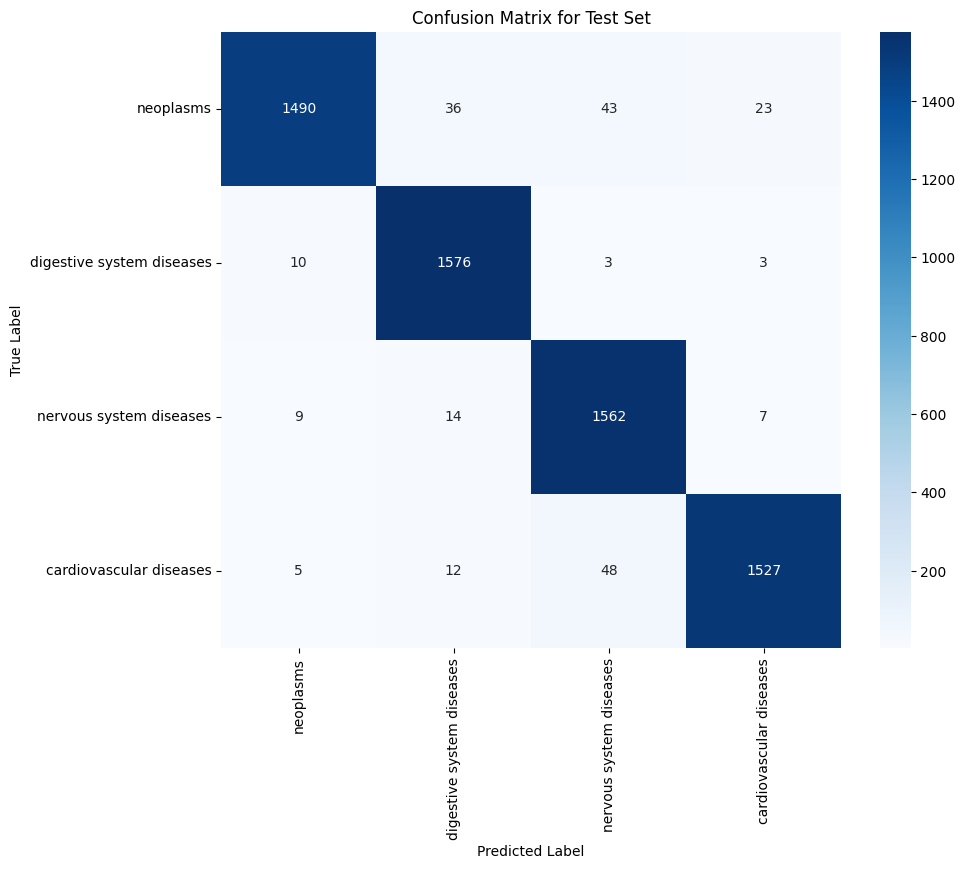

                           precision    recall  f1-score   support

                neoplasms       0.98      0.94      0.96      1592
digestive system diseases       0.96      0.99      0.98      1592
  nervous system diseases       0.94      0.98      0.96      1592
  cardiovascular diseases       0.98      0.96      0.97      1592

                 accuracy                           0.97      6368
                macro avg       0.97      0.97      0.97      6368
             weighted avg       0.97      0.97      0.97      6368



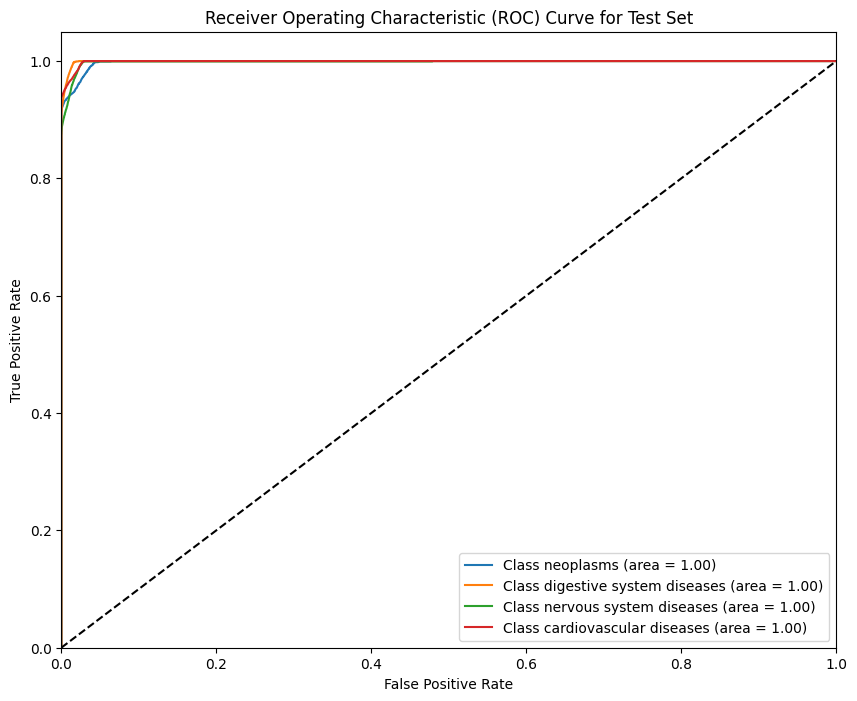

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

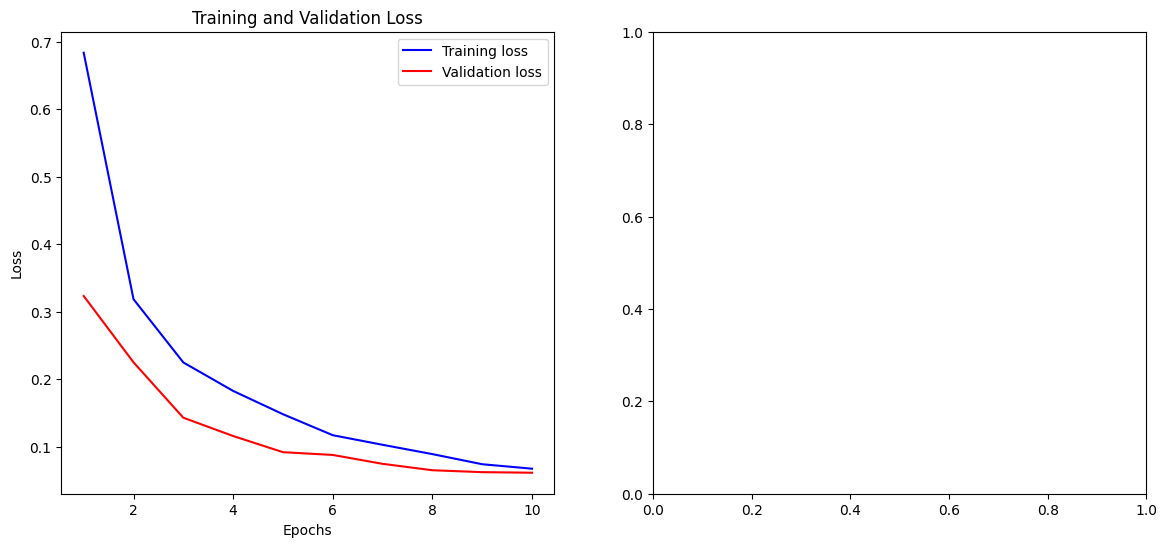

In [25]:
# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Evaluation results on validation set: {eval_results}")

# Evaluate the model on the test set
test_results = trainer.predict(test_dataset)
test_preds = np.argmax(test_results.predictions, axis=1)
test_labels = test_results.label_ids

# Calculate precision, recall, f1-score for test set
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Confusion matrix for test set
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_dict.values(), yticklabels=label_dict.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Classification report for test set
test_report = classification_report(test_labels, test_preds, target_names=label_dict.values())
print(test_report)

# ROC Curve and AUROC for test set
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_dict)):
    fpr[i], tpr[i], _ = roc_curve(test_labels, test_results.predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(label_dict)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_dict[i+1]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
plt.show()

# Extract losses and accuracy values
training_logs = trainer.state.log_history

train_loss_values = [log['loss'] for log in training_logs if 'loss' in log]
val_loss_values = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]
train_acc_values = [log['accuracy'] for log in training_logs if 'accuracy' in log]
val_acc_values = [log['eval_accuracy'] for log in training_logs if 'eval_accuracy' in log]

# Ensure equal length for plotting
min_len = min(len(train_loss_values), len(val_loss_values))
train_loss_values = train_loss_values[:min_len]
val_loss_values = val_loss_values[:min_len]
train_acc_values = train_acc_values[:min_len]
val_acc_values = val_acc_values[:min_len]
epochs = range(1, min_len + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluate the model on the test set
test_results = trainer.predict(test_dataset)
test_preds = np.argmax(test_results.predictions, axis=1)
test_labels = test_results.label_ids

# Calculate precision, recall, f1-score for test set
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Confusion matrix for test set
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_dict.values(), yticklabels=label_dict.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Classification report for test set
test_report = classification_report(test_labels, test_preds, target_names=label_dict.values())
print(test_report)

# ROC Curve and AUROC for test set
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_dict)):
    fpr[i], tpr[i], _ = roc_curve(test_labels, test_results.predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(label_dict)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_dict[i+1]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
plt.show()

# Extract losses and accuracy values
training_logs = trainer.state.log_history

train_loss_values = [log['loss'] for log in training_logs if 'loss' in log]
val_loss_values = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]
train_acc_values = [log['accuracy'] for log in training_logs if 'accuracy' in log]
val_acc_values = [log['eval_accuracy'] for log in training_logs if 'eval_accuracy' in log]

# Ensure equal length for plotting
min_len = min(len(train_loss_values), len(val_loss_values))
train_loss_values = train_loss_values[:min_len]
val_loss_values = val_loss_values[:min_len]
train_acc_values = train_acc_values[:min_len]
val_acc_values = val_acc_values[:min_len]
epochs = range(1, min_len + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

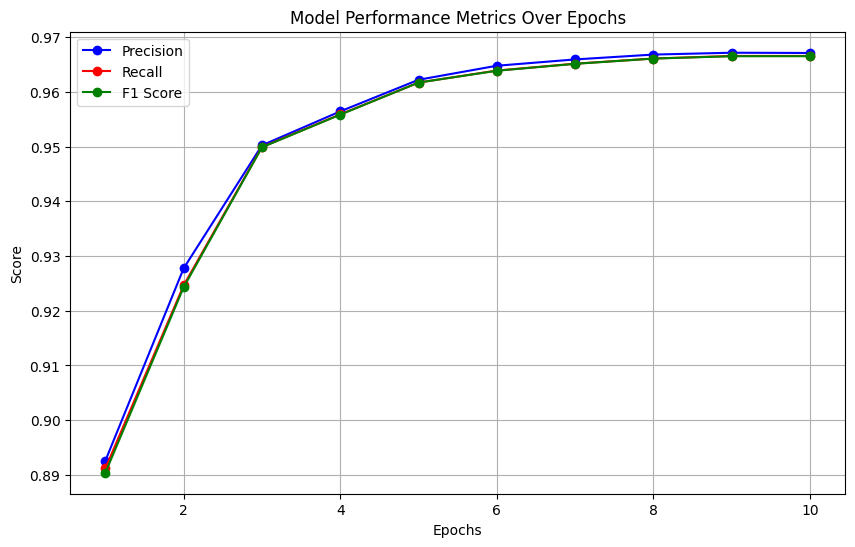

In [26]:
import matplotlib.pyplot as plt

# Data for the new set of epochs
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
precision = [0.892583, 0.927742, 0.950213, 0.956422, 0.962196, 0.964761, 0.965915, 0.966802, 0.967141, 0.967095]
recall = [0.891175, 0.924623, 0.949906, 0.955873, 0.961683, 0.963882, 0.965138, 0.966080, 0.966552, 0.966552]
f1 = [0.890386, 0.924287, 0.949862, 0.955820, 0.961688, 0.963844, 0.965108, 0.966071, 0.966499, 0.966504]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, precision, 'b-o', label='Precision')
plt.plot(epochs, recall, 'r-o', label='Recall')
plt.plot(epochs, f1, 'g-o', label='F1 Score')

# Titles and labels
plt.title('Model Performance Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


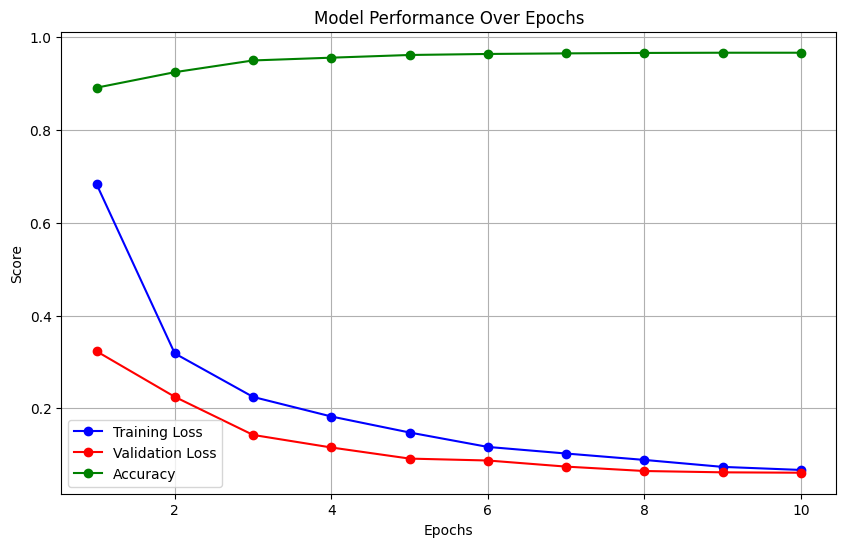

In [27]:
import matplotlib.pyplot as plt

# Data for the new set of epochs
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
training_loss = [0.683500, 0.318400, 0.224700, 0.182500, 0.148000, 0.116900, 0.102700, 0.088900, 0.073900, 0.067300]
validation_loss = [0.323128, 0.224885, 0.142800, 0.115698, 0.091762, 0.087657, 0.074491, 0.065007, 0.062176, 0.061329]
accuracy = [0.891175, 0.924623, 0.949906, 0.955873, 0.961683, 0.963882, 0.965138, 0.966080, 0.966552, 0.966552]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'b-o', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-o', label='Validation Loss')
plt.plot(epochs, accuracy, 'g-o', label='Accuracy')

# Titles and labels
plt.title('Model Performance Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Show plot
plt.show()
